<p style = "background-color : #1c00ff; border-radius: 5px 5px; padding : 15px"><strong>

# Titanic - Machine Learning from Disaster

<p style = "background-color : #1c00ff; border-radius: 5px 5px; padding : 15px"><strong>



<div style="text-align: center;">
    <img src="png//one.png" alt="one" width="600"/>
</div>

In [50]:
# Расчёты
import numpy as np
import pandas as pd
import re
import time


# Модели
from sklearn.ensemble import(
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    HistGradientBoostingClassifier
)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance

import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Тесты
from sklearn.feature_selection import f_classif # anova

# Для распечатки в цвете:
from termcolor import colored

# Убираем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [51]:
df_train = pd.read_csv('data//train.csv') # датасет для обучения
df_test = pd.read_csv('data//test.csv') # датасет для предсказания
submission = pd.read_csv('data//gender_submission.csv') 

# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Survived'] = 0 # в тесте у нас нет значения Survived, мы его должны предсказать, по этому пока просто заполняем нулями



# обьединяем датасеты в один, для более удобной работы с одной датасетом, а не двумя.asas
df_titan = pd.concat([df_train, df_test], ignore_index = True)


In [52]:
df_titan

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sample
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
1305,1306,0,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
1307,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Признаки: </span>

<div class="alert alert-info">

- <span style="color:#0090ff">**PassengerId**</span> - Номер пассажира
- <span style="color:#0090ff">**Survived**</span> - Выживание. 0 - Нет, 1 - Да (Целевая переменная)
- <span style="color:#0090ff">**Pclass**</span> - Класс билета 1 - первый, 2-второй, 3-тий
- <span style="color:#0090ff">**Name**</span> - Имя посетителей
- <span style="color:#0090ff">**Sex**</span> - Пол
- <span style="color:#0090ff">**Age**</span> - Возраст
- <span style="color:#0090ff">**SibSp**</span> - Количество братьев и сестер на борту/ супругов
- <span style="color:#0090ff">**Parch**</span> - Количество родителей / детей на борту
- <span style="color:#0090ff">**Ticket**</span> - Номер билета
- <span style="color:#0090ff">**Fare**</span> - Стоимость проезда для пассажиров
- <span style="color:#0090ff">**Cabin**</span> - Номер каюты
- <span style="color:#0090ff">**Embarked**</span> - Порт посадки C =  Cherbourg, Q=Queenstown, S= Southampton

<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Что у нас по данным: </span>

In [53]:
df_titan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  sample       1309 non-null   int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 133.1+ KB


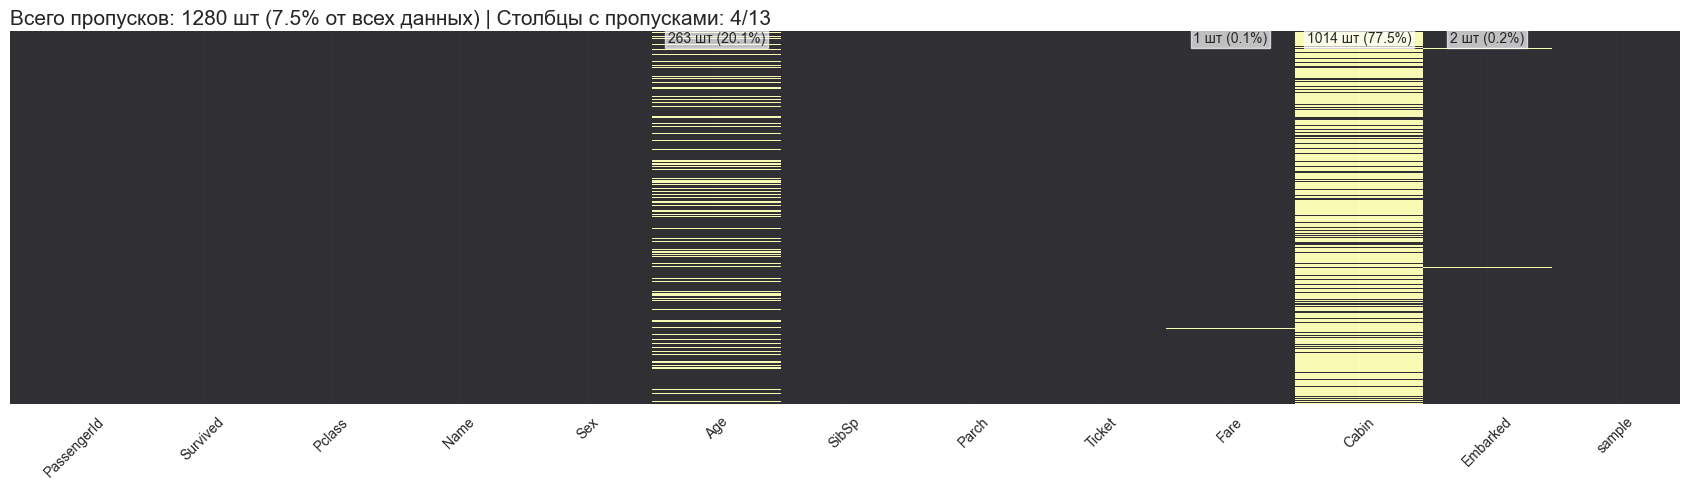

In [54]:
plt.figure(figsize=(17, 5))  # Увеличиваем высоту для заголовка

# расчет общего числа пропусков
total_missing = df_titan.isnull().sum().sum()
columns_missing = df_titan.isnull().sum()

# график
ax = sns.heatmap(
    df_titan.isnull(),
    cbar=False,
    cmap="inferno",
    yticklabels=False,
    alpha=0.8
)

# Аннотации для столбцов
for i, col in enumerate(df_titan.columns):
    missing = columns_missing[col]
    if missing > 0:
        ax.text(
            i + 0.5, 
            -0.2, 
            f"{missing} шт ({missing/len(df_titan):.1%})",  # Добавляем процент
            ha='center', 
            va='top', 
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7, pad=2)  # Подложка для читаемости
        )

# Заголовок
plt.title(
    f'Всего пропусков: {total_missing} шт ({total_missing/df_titan.size:.1%} от всех данных) | '
    f'Столбцы с пропусками: {sum(columns_missing > 0)}/{len(df_titan.columns)}',
    pad=5, # Отступ
    fontsize=15, # Размер
    loc='left' # Положение 
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div class="alert alert-danger">

По итогу 263 шт у `Age`, в трейне нарисовался 1 пропуск `Fare`, `Cabin` - можно сразу удалять, и чуток поработаем над `Embarked`

<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Поехали разбираться с пропусками:</span>

<div style="text-align: center;">
    <img src="png//png.jpg" alt="one" width="700"/>
</div>

In [55]:
df_titan['Has_Cabin'] = df_titan['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
# Думаю больше с признаком Cabin особо ничего не сделать, он еле живёт, поэтому удалим его сразу:
del df_titan['Cabin']

<div class="alert alert-info">

С признаком Age не всё так однозначно. Поэтому попробуем его воскресить с помощью заполнения.
Из способов заполнения можно, конечно рассмотреть: 
- среднее `df['Age'].fillna(df['Age'].mean(), inplace=True)`
- медиана  `df['Age'].fillna(df['Age'].median(), inplace=True)`
- мода  `df['Age'].fillna(df['Age'].mode(), inplace=True)`

Каждый случай может подстраиваться под данные в зависимости от распределения, устойчивости к выбросам, категории данных и т.п.
В нашем случае я предположил, что есть некие зависимости между признакими Age и другими, к примеру тип и состав семьи, пол - ведь ситуация с финансами в зависимости от пола в те времена могла сильнее отличаться от нынешних реалий и не была одинакова, класс билета, который может себе позволить посетитель, думаю, что возможно будет какая-то логика присутствовать исходя из возможностей пассажира и его возраста.





Стоит обратить внимание при заполнении пропусков, что у нас в данных есть test, и воизбежании утечки данных, мы признаки будем заполнять без учета test

<!--  -->

In [56]:
# 1. Переведем колонку Sex в бинарный вид:
df_titan['Sex'] = df_titan['Sex'].apply(lambda x: 1 if x =='male' else 0) 

# 2. Разделяем данные на те, где Age есть и где пропущено
known_age = df_titan[(df_titan['Age'].notna()) & (df_titan['sample'] == 1)]
unknown_age = df_titan[df_titan['Age'].isna()]


# 3. делим на признаки и целевую переменную
X = known_age[['Sex', 'Pclass', 'SibSp', 'Parch']]
y = known_age['Age']

<div class="alert alert-info">

Используем модель RandomForest, т.к. она не требует предварительной нормализации данных (в отличие от линейных моделей) и автоматически игнорирует выбросы при построении деревьев.

In [57]:
# 4. Выбор и обучение модели
model = RandomForestRegressor().fit(X, y)

# 5. Предсказываем пропуски
predicted_age = model.predict(unknown_age[['Sex', 'Pclass', 'SibSp', 'Parch']])
df_titan.loc[df_titan['Age'].isna(), 'Age'] = predicted_age

In [58]:
# Чекним Age
df_titan.Age

0       22.000000
1       38.000000
2       26.000000
3       35.000000
4       35.000000
          ...    
1304    29.149825
1305    39.000000
1306    38.500000
1307    29.149825
1308    20.291368
Name: Age, Length: 1309, dtype: float64

<div class="alert alert-info">

Мы видим, что многие пропущенные значения Age после обучения и до были дробные..Это конечно здорово такая точность, но в жизни таких возрастов быть не может, поэтому округлим на основе математических правил до ближайшего целого 

In [59]:
df_titan['Age'] = df_titan['Age'].round()

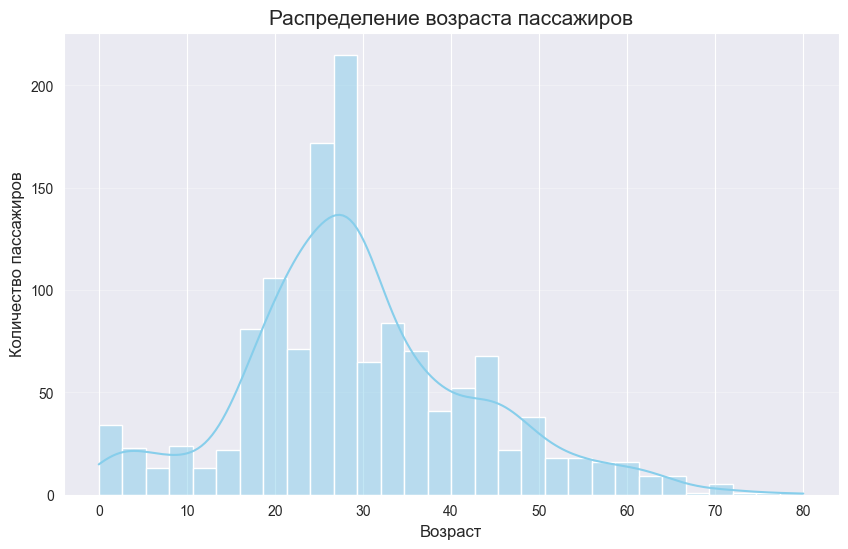

In [60]:
# Визуализируем что у нас вышло:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_titan, x='Age', bins=30, kde=True, color='skyblue')
plt.title('Распределение возраста пассажиров', fontsize=15)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество пассажиров', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

<div class="alert alert-info">

Вроде картина не плохая с признаком `["Age"]`, теперь завершим работу над пропусками с признаком `['Embarked']`. Там всего 2 строки, заполним их модой

In [61]:
# Находим моду (самое частое значение)
emb_mode = df_titan[df_titan['sample']==1]['Embarked'].mode()[0]
# Заполняем пропуски
df_titan['Embarked'] = df_titan['Embarked'].fillna(emb_mode)

<div class="alert alert-info">

Также в test был обнаружен пропуск в значении стоимости билета `["Fare"]`, заполним его медианой на основе класса `['Pclass']`.

НО стоит обратить внимание, что эти данные отсутствуют в тесте, поэтому заполним на основе только тестовых данных заполним

In [62]:
# Заполняем пропуски в Fare медианой по Pclass, но только на основе тестовых данных
test_median_fares = df_titan[df_titan['sample'] == 0].groupby('Pclass')['Fare'].median()
df_titan['Fare'] = df_titan.groupby('Pclass')['Fare'].transform(
    lambda x: x.fillna(test_median_fares[x.name])
)

<div class="alert alert-info">

Чекним пропуска

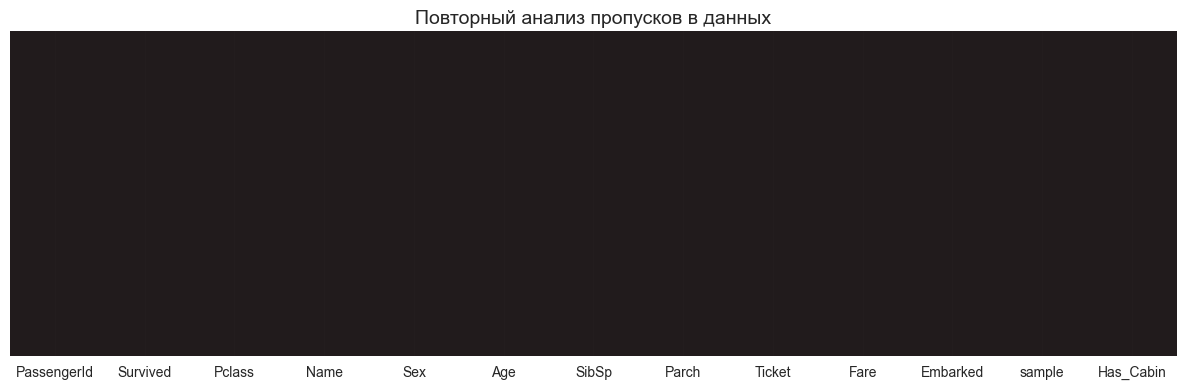

In [63]:
plt.figure(figsize=(12, 4)) 
ax = sns.heatmap(
    df_titan.isnull(),
    cbar=False,
    cmap="mako",
    yticklabels=False,  # Убираем подписи строк для чистоты
    alpha=0.9
)

plt.title("Повторный анализ пропусков в данных", pad=5, fontsize=14)
plt.tight_layout()
plt.show()


## Чистота


<div style="text-align: left;">
    <img src="png//isnull.jpg" alt="one" width="700"/>
</div>

<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Пройдемся по остальным признакам, и попробуем расширить их:</span>

<center><p style = "background-color : white; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">Ticket</span>

<div class="alert alert-warning alert-dismissible">

Меня заинтересовал признак Ticket, он имеет разные обозначения, где-то цифры, где-то буквы. 
Найдены были следующие возможные разделения

<div style="text-align: center;">
    <img src="png//ticket.png" alt="one" width="500"/>
</div>

<div class="alert alert-warning alert-dismissible">

##### 1. Разные классы обслуживания
Билеты 1-го класса чаще содержали префиксы (буквы), указывающие на тип каюты или услуги:
- **PC (Parliamentary Class)** — для высокопоставленных лиц.
- **C, CA (Cabin)** — каютные билеты.
- **SC (Service Class)** — для сотрудников судоходной компании.

Билеты 2-го и 3-го класса обычно были просто цифровыми (например, 347082).

##### 2. Групповые билеты (семьи, слуги)
Некоторые билеты имели префикс **LINE** или **FCC**, если покупались оптом (например, для семьи с прислугой).  
Пример: билет **LINE/1** был куплен для группы пассажиров, путешествующих вместе.

##### 3. Специальные категории пассажиров
Сотрудники судоходной компании (White Star Line) получали билеты с префиксом **SOTON (Southampton)**.  
Пересадочные пассажиры (с других кораблей) могли иметь префиксы вроде **A/5**.

##### 4. Разные кассы продаж
Билеты, купленные в разных офисах (Лондон, Саутгемптон, Шербур), могли иметь свои уникальные префиксы.  
Например, билеты, начинающиеся с **W**, продавались в Саутгемптоне.

##### 5. Технические причины
Часть билетов была аннулирована или заменена, и новые номера выдавались вручную, что приводило к неоднородности.  
Некоторые префиксы (например, **STON**) обозначали тип места (STON = Stone, каменные палубы для 3-го класса).


##### Пример билета и расшифровки

| Билет          | Объяснение                                                  |
|----------------|------------------------------------------------------------|
| 113781         | Обычный билет 1-го класса (без префикса).                 |
| C.A. 24579     | Каютный билет (C.A. = Cabin Assignment).                  |
| SC/PARIS 2147  | Билет сотрудника компании (SC = Service Class, PARIS = маршрут). |
| A/5 21171      | Групповой или пересадочный билет.                          |



###### Ниже был анализ префикса билета - он после рассмотрения признаков нам не к чему, убрал код

In [64]:
# # Извлекаем префикс билета
# def extract_ticket_prefix(ticket):
#     """Функция для извлечения буквенной части (префикса) из номера билета
#     """    
#     match = re.match(r'^([A-Za-z\.\/]+)', ticket) # Пытаемся найти префикс
#     return match.group(1) if match else 'NoPrefix' # Возвращаем найденное или 'NoPrefi

# # Применяем функцию
# df_titan['Ticket_Prefix'] = df_titan['Ticket'].apply(extract_ticket_prefix)

# # Упрощаем редкие префиксы
# df_titan['Ticket_Prefix'] = df_titan['Ticket_Prefix'].replace({
#     'A/5': 'A5',
#     'PC': 'PC',
#     'STON/O2.': 'STON',
#     'C.A.': 'CA',
#     'SC/Paris': 'SC',
#     'PP': 'PP',
#     'SOTON/OQ': 'SOTON',
#     'LINE': 'LINE'
# })


In [65]:
# Извлекаем числовую часть
def extract_ticket_number(ticket):
    """Функция для извлечения числовой части билета
    """    
    numbers = re.findall(r'\d+', ticket)
    return int(numbers[-1]) if numbers else -1

# Применяем функцию
df_titan['Ticket_Number'] = df_titan['Ticket'].apply(extract_ticket_number)

In [66]:
# В зависимости от длинны
df_titan['Ticket_Length'] = df_titan['Ticket'].apply(len)

In [67]:
# Содержит ли билет буквы 
df_titan['Ticket_HasLetters'] = df_titan['Ticket'].apply(lambda x: 1 if any(c.isalpha() for c in x) else 0)

In [68]:
# Люди с одинаковым номером билета могли путешествовать вместе
df_titan['Ticket_GroupSize'] = df_titan.groupby('Ticket_Number')['Ticket_Number'].transform('count')

In [69]:
# сразу уберем переваренный признак Ticket поэтому удалим его сразу:
del df_titan['Ticket']

<center><p style = "background-color : white; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">Name</span>


<div class="alert alert-warning alert-dismissible">

Казалось бы признак Name - для чего он там? Ведь имея не сделает тебя спасённым..

<div style="text-align: center;">
    <img src="png//people.png" alt="one" width="700"/>
</div>

<div class="alert alert-warning alert-dismissible">

НО! Мы можем извлечь социальный статус, титулы и семейные связи, которые коррелируют с выживаемостью, к примеры главы семейств (часто мужчины) могли жертвовать собой, длина имени, может указывать на какую-то аристократию и указывать что человек богат, определенные титулы которые отвечают за детей или женщин могли быть в приоритете, или как их распределяли по шлюпкам?

In [70]:
# Извлечем титулы
def extract_title(name):
    """Функция для извлечения титула
    """    
    title = re.search(r' ([A-Za-z]+)\.', name)
    return title.group(1) if title else 'NoTitle'

df_titan['Title'] = df_titan['Name'].apply(extract_title)

# Упрощаем редкие титулы
df_titan['Title'] = df_titan['Title'].replace([
    'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'
], 'Rare')

df_titan['Title'] = df_titan['Title'].replace('Mlle', 'Miss')
df_titan['Title'] = df_titan['Title'].replace('Ms', 'Miss')
df_titan['Title'] = df_titan['Title'].replace('Mme', 'Mrs')

# Проверяем распределение
print(df_titan['Title'].value_counts())

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64


<div class="alert alert-warning alert-dismissible">

Проверим наши предположения

In [71]:
# Группируем по Title и Survived, считаем количество пассажиров
title_survival = df_titan.groupby(['Title', 'Survived'])['PassengerId'].count().unstack()
title_survival.columns = ['Died', 'Survived']  # Переименовываем колонки
title_survival['Total'] = title_survival.sum(axis=1)  # Общее количество пассажиров
title_survival['Survival_Rate'] = title_survival['Survived'] / title_survival['Total'] * 100  # Процент выживших

print(title_survival)

        Died  Survived  Total  Survival_Rate
Title                                       
Master    38        23     61      37.704918
Miss     134       130    264      49.242424
Mr       676        81    757      10.700132
Mrs       98       100    198      50.505051
Rare      21         8     29      27.586207


<Figure size 1200x600 with 0 Axes>

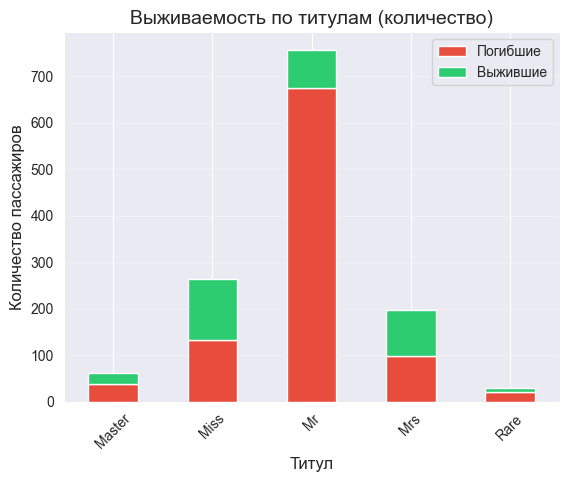

In [72]:
plt.figure(figsize=(12, 6))
title_survival[['Died', 'Survived']].plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
plt.title('Выживаемость по титулам (количество)', fontsize=14)
plt.xlabel('Титул', fontsize=12)
plt.ylabel('Количество пассажиров', fontsize=12)
plt.xticks(rotation=45)
plt.legend(['Погибшие', 'Выжившие'])
plt.grid(axis='y', alpha=0.3)
plt.show()

<div class="alert alert-warning alert-dismissible">

Действительно среди мужчин больше погибших, а женшин выживших, у детей идет 50х50 варианты

In [73]:
# Признак глав семьи
df_titan['Is_Family_Head'] = df_titan.apply(
    lambda x: 1 if (x['SibSp'] > 0 or x['Parch'] > 0) and x['Title'] == 'Mr' else 0,
    axis=1
)

In [74]:
# Длина имени
df_titan['Name_Length'] = df_titan['Name'].apply(len)

In [75]:
# Взглянем, что вышло
df_titan[['Title', 'Name_Length', 'Is_Family_Head']]

,Title,Name_Length,Is_Family_Head
0,Mr,23,1
1,Mrs,51,0
2,Miss,22,0
3,Mrs,44,0
4,Mr,24,0
...,...,...,...
1304,Mr,18,0
1305,Rare,28,0
1306,Mr,28,0
1307,Mr,19,0


In [76]:
# Создание признака размер семьи
df_titan['Family_Size'] = df_titan['SibSp'] + df_titan['Parch']

In [77]:
# Создание признак (Путешествует один)
df_titan['Is_Alone'] = df_titan['Family_Size'].apply(lambda x: 1 if x == 0 else 0)

In [78]:
# Предполагаю, что признак Name нам больше не нужен:
del df_titan['Name']

In [79]:
# Биннинг возраста
df_titan['Age_Bin'] = pd.cut(df_titan['Age'], bins=[0, 12, 18, 30, 50, 100], labels=['Child', 'Teen', 'Young', 'Adult', 'Elderly'])

In [80]:
df_titan

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,sample,...,Ticket_Number,Ticket_Length,Ticket_HasLetters,Ticket_GroupSize,Title,Is_Family_Head,Name_Length,Family_Size,Is_Alone,Age_Bin
0,1,0,3,1,22.0,1,0,7.2500,S,1,...,21171,9,1,1,Mr,1,23,1,0,Young
1,2,1,1,0,38.0,1,0,71.2833,C,1,...,17599,8,1,2,Mrs,0,51,1,0,Adult
2,3,1,3,0,26.0,0,0,7.9250,S,1,...,3101282,16,1,1,Miss,0,22,0,1,Young
3,4,1,1,0,35.0,1,0,53.1000,S,1,...,113803,6,0,2,Mrs,0,44,1,0,Adult
4,5,0,3,1,35.0,0,0,8.0500,S,1,...,373450,6,0,1,Mr,0,24,0,1,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,1,29.0,0,0,8.0500,S,0,...,3236,9,1,1,Mr,0,18,0,1,Young
1305,1306,0,1,0,39.0,0,0,108.9000,C,0,...,17758,8,1,3,Rare,0,28,0,1,Adult
1306,1307,0,3,1,38.0,0,0,7.2500,S,0,...,3101262,18,1,1,Mr,0,28,0,1,Adult
1307,1308,0,3,1,29.0,0,0,8.0500,S,0,...,359309,6,0,1,Mr,0,19,0,1,Young


In [81]:
# Выбираем категориальные признаки
categorical_features = ['Embarked', 'Title', 'Age_Bin']

# Создаём и применяем OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' убирает мультиколлинеарность
encoded_features = encoder.fit_transform(df_titan[categorical_features])

# Преобразуем в DataFrame и добавляем обратно
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df_titan = pd.concat([df_titan.drop(categorical_features, axis=1), encoded_df], axis=1)

In [82]:
# Выбираем числовые признаки для масштабирования
numeric_to_scale = ['Age', 'Fare', 'Name_Length']

# Масштабируем
scaler = StandardScaler()
df_titan[numeric_to_scale] = scaler.fit_transform(df_titan[numeric_to_scale])

In [83]:
df_titan.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [84]:
df_titan

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,sample,Has_Cabin,...,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age_Bin_Child,Age_Bin_Elderly,Age_Bin_Teen,Age_Bin_Young,Age_Bin_nan
0,1,0,3,1,-0.575796,1,0,-0.503173,1,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1,1,0,0.623078,1,0,0.734810,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,3,0,-0.276077,0,0,-0.490123,1,0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,1,1,0,0.398289,1,0,0.383265,1,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,3,1,0.398289,0,0,-0.487707,1,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,1,-0.051289,0,0,-0.487707,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1305,1306,0,1,0,0.698007,0,0,1.462070,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1306,1307,0,3,1,0.623078,0,0,-0.503173,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,1308,0,3,1,-0.051289,0,0,-0.487707,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [85]:
# Делим признаки на количественные и категориальные признаки:

# количественные:
num_cols = [
    # признаки, связанные с анализом эмоциональной окраски отзывов:
    'Age', 'Fare', 'SibSp', 'Parch', 'Ticket_Length', 'Ticket_GroupSize', 'Name_Length',
]

# Категориальные:
cat_cols = [
    'Pclass', 'Sex', 'Ticket_Number', 'Ticket_HasLetters',
       'Is_Family_Head', 'Embarked_Q',
       'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 
       'Title_Rare','Family_Size', 'Is_Alone','Has_Cabin'
]

In [86]:
# Построение корреляционных графиков
def build_corr(df, columns, title, method):
    """Функция по построению графиков

    Args:
        df: датасет
        columns: Название колонок
        title: Название графика
        method: _description_
    """    
    fig_, ax_ = plt.subplots(figsize=(20, 15))
    corr = df[columns].corr(method=method).abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True,
                annot_kws={"fontsize":9}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='Pastel1_r',
                fmt='.2f')
    ax_.set_title(title, fontsize=18)
    plt.show()

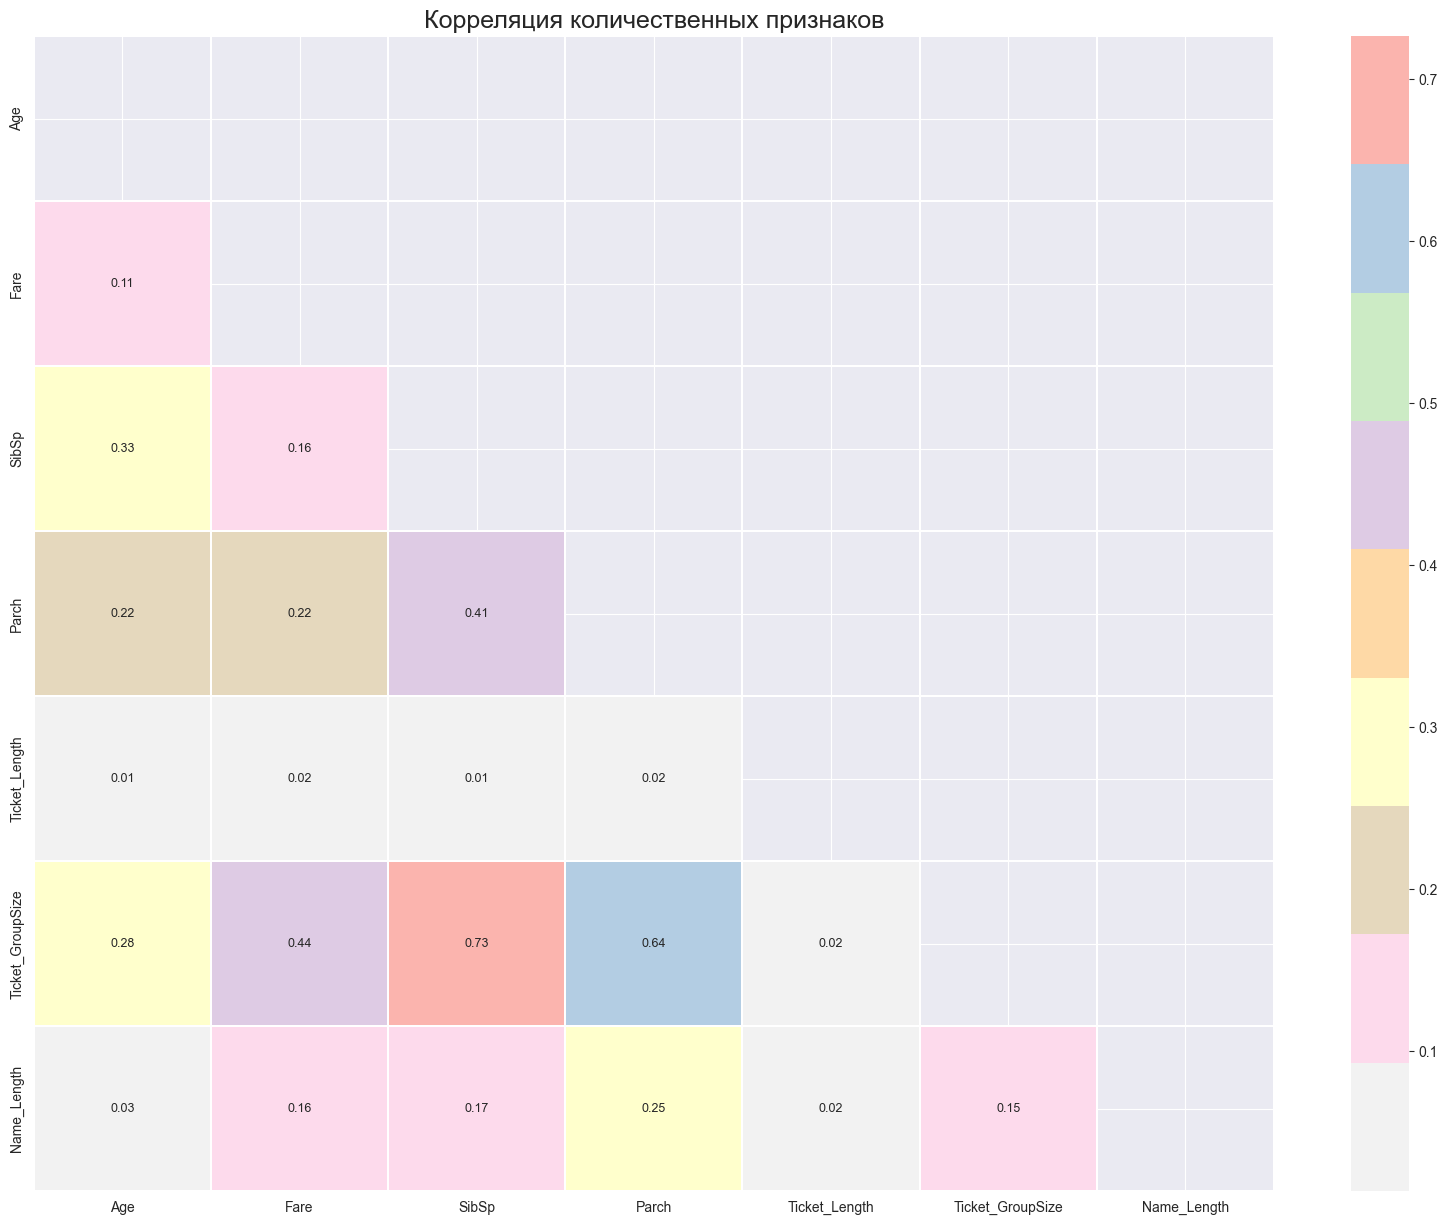

In [87]:
# Смотрим корреляцию непрерывных призанков
build_corr(df_titan[df_titan['sample']==1], num_cols, 'Корреляция количественных признаков', 'pearson')

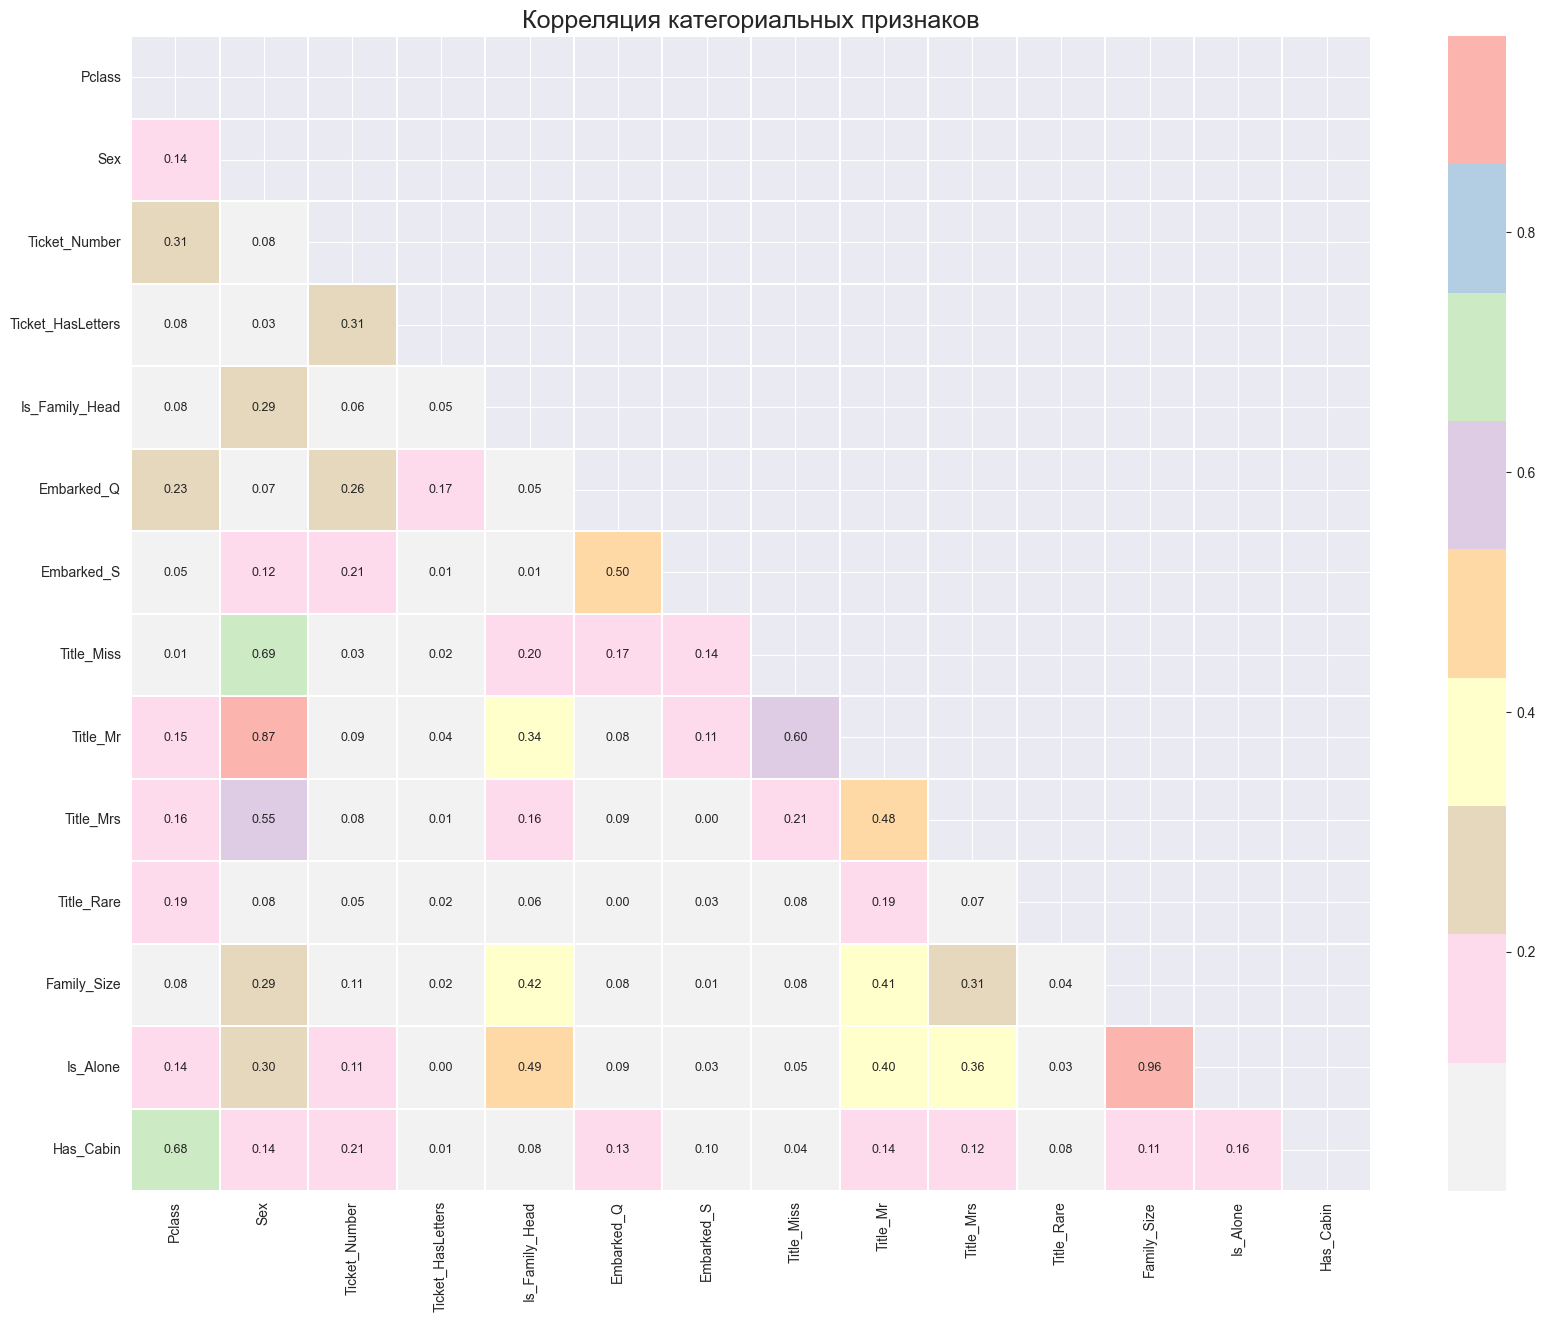

In [88]:
build_corr(df_titan[df_titan['sample']==1], cat_cols, 'Корреляция категориальных признаков', 'spearman')

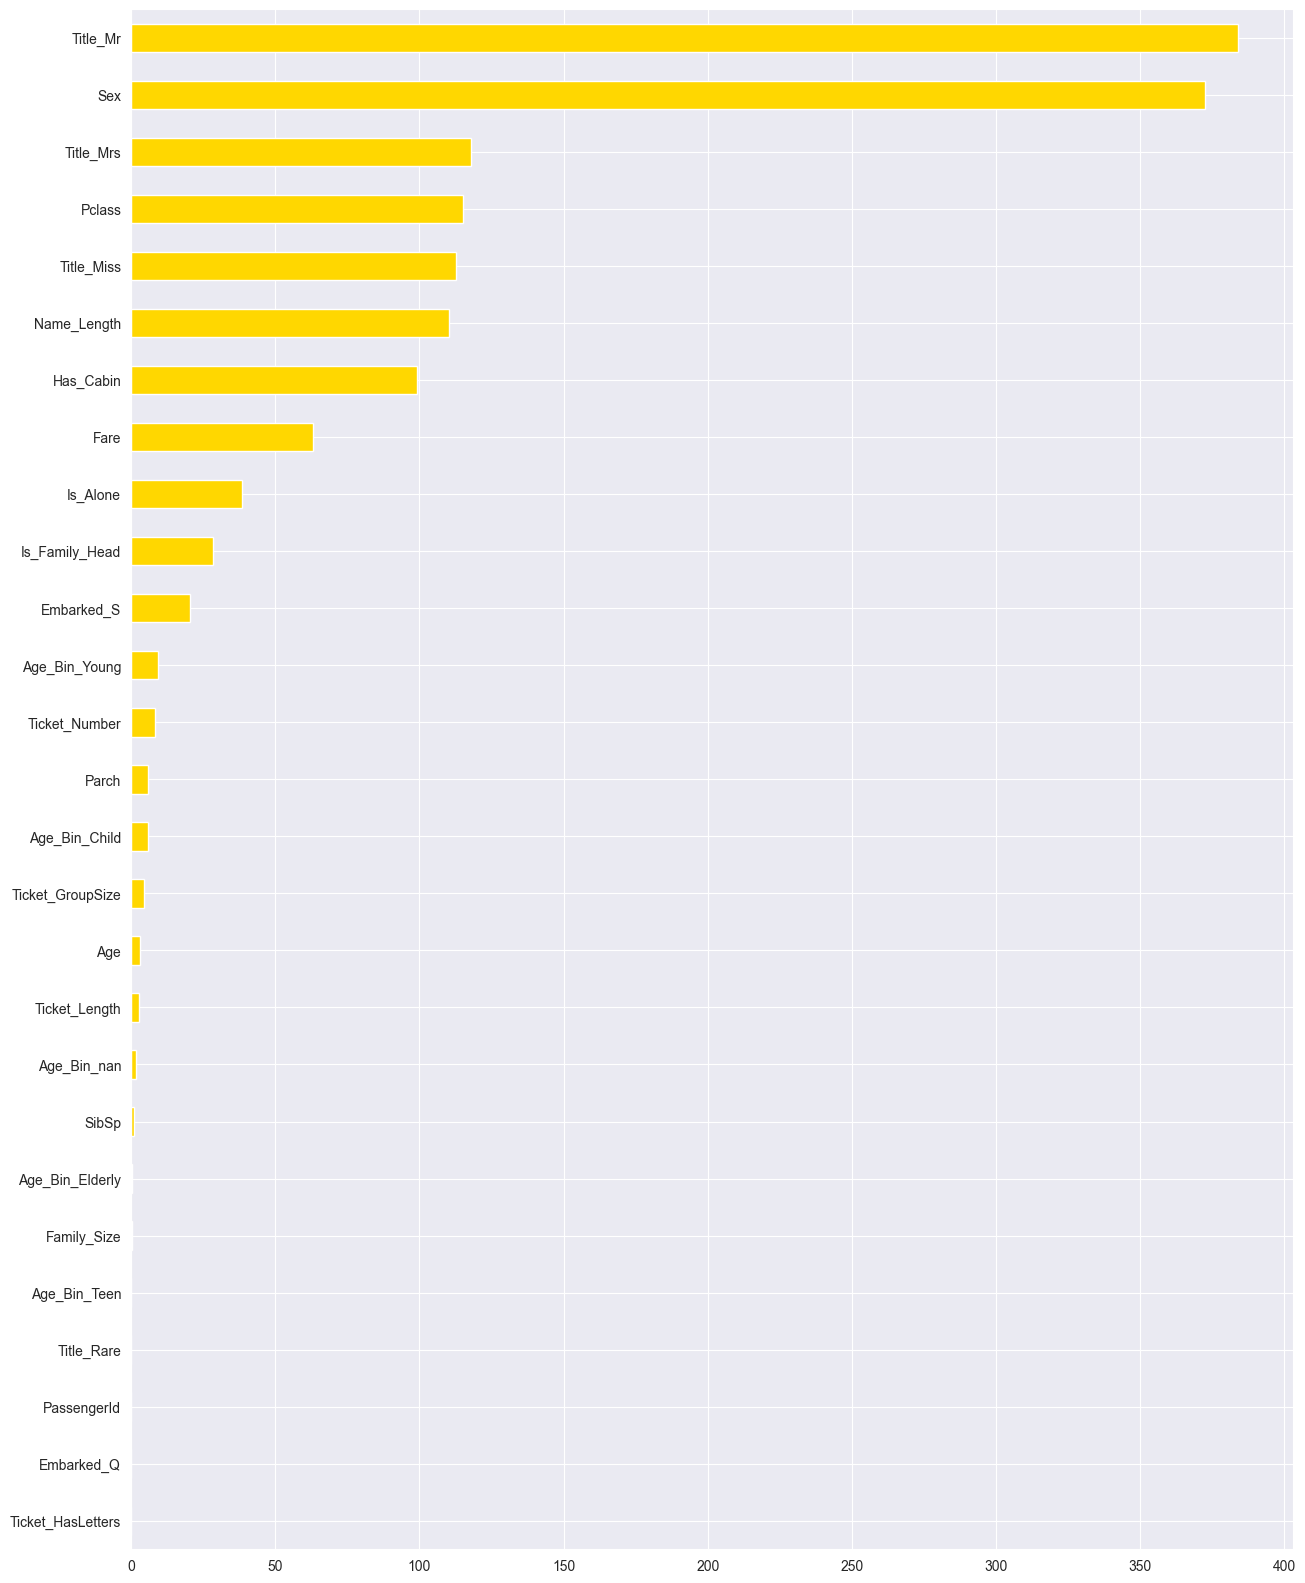

In [89]:
# Оценку значимости признаков выполним дисперсионным анализом Anova:
y = df_titan.query('sample == 1').drop(['sample'], axis=1).Survived.values
X = df_titan.query('sample == 1').drop(['sample', 'Survived'], axis=1)

# визуализируем результат анализа значимости:
imp_nc = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_nc.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(15, 20))
imp_nc.plot(kind = 'barh', color='gold');

In [90]:
df_titan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        1309 non-null   int64  
 1   Survived           1309 non-null   int64  
 2   Pclass             1309 non-null   int64  
 3   Sex                1309 non-null   int64  
 4   Age                1309 non-null   float64
 5   SibSp              1309 non-null   int64  
 6   Parch              1309 non-null   int64  
 7   Fare               1309 non-null   float64
 8   sample             1309 non-null   int64  
 9   Has_Cabin          1309 non-null   int64  
 10  Ticket_Number      1309 non-null   int64  
 11  Ticket_Length      1309 non-null   int64  
 12  Ticket_HasLetters  1309 non-null   int64  
 13  Ticket_GroupSize   1309 non-null   int64  
 14  Is_Family_Head     1309 non-null   int64  
 15  Name_Length        1309 non-null   float64
 16  Family_Size        1309 

<div class="alert alert-info">

Хоть и есть корреляция между признакими Sex и Title_Mr - я их всё же оставлю. 

<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Перейдем непосредственно к обучению:</span>

<div style="text-align: center;">
    <img src="png//learnm.jpg" alt="one" width="1000"/>
</div>

In [91]:
# Список моделей для сравнения
models = [
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('GradientBoosting', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=42)),
    ('Bagging', BaggingClassifier(n_estimators=100, random_state=42)),
    ('HistGradientBoosting', HistGradientBoostingClassifier(random_state=42)),
    ('XGBoost', xgb.XGBClassifier(n_estimators=100, random_state=42)),
    ('LightGBM', LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)),
    ('CatBoost', CatBoostClassifier(iterations=100, random_state=42, verbose=0)) 
]

In [92]:
# Метрики для оценки (только accuracy)
scoring = ['accuracy']

# Обучаем и оцениваем модели с кросс-валидацией
results = []
feature_importances = {}

for name, model in models:
    print(f"\n{'='*50}\nОбучение {name}...")
    start_time = time.time()
    
    # Для CatBoost временно отключаем параллельное выполнение
    if name == 'CatBoost':
        cv_results = cross_validate(
            model, X, y, cv=5, scoring=scoring, n_jobs=1, return_train_score=False
        )
    else:
        cv_results = cross_validate(
            model, X, y, cv=5, scoring=scoring, n_jobs=-1, return_train_score=False
        )
    
    # Время обучения
    train_time = time.time() - start_time
    
    # Вычисляем средние значения метрик
    metrics = {
        'Model': name,
        'Accuracy': np.mean(cv_results['test_accuracy']),
        'Accuracy_std': np.std(cv_results['test_accuracy']),
        'Time (s)': train_time
    }
    
    results.append(metrics)
    
    # Обучаем модель на всех данных для анализа важности признаков
    model.fit(X, y)
    
    # Получаем важность признаков
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        # Для моделей без .feature_importances_ используем permutation importance
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
        importances = result.importances_mean
    
    feature_importances[name] = importances


Обучение RandomForest...

Обучение GradientBoosting...

Обучение ExtraTrees...

Обучение AdaBoost...

Обучение Bagging...

Обучение HistGradientBoosting...

Обучение XGBoost...

Обучение LightGBM...

Обучение CatBoost...


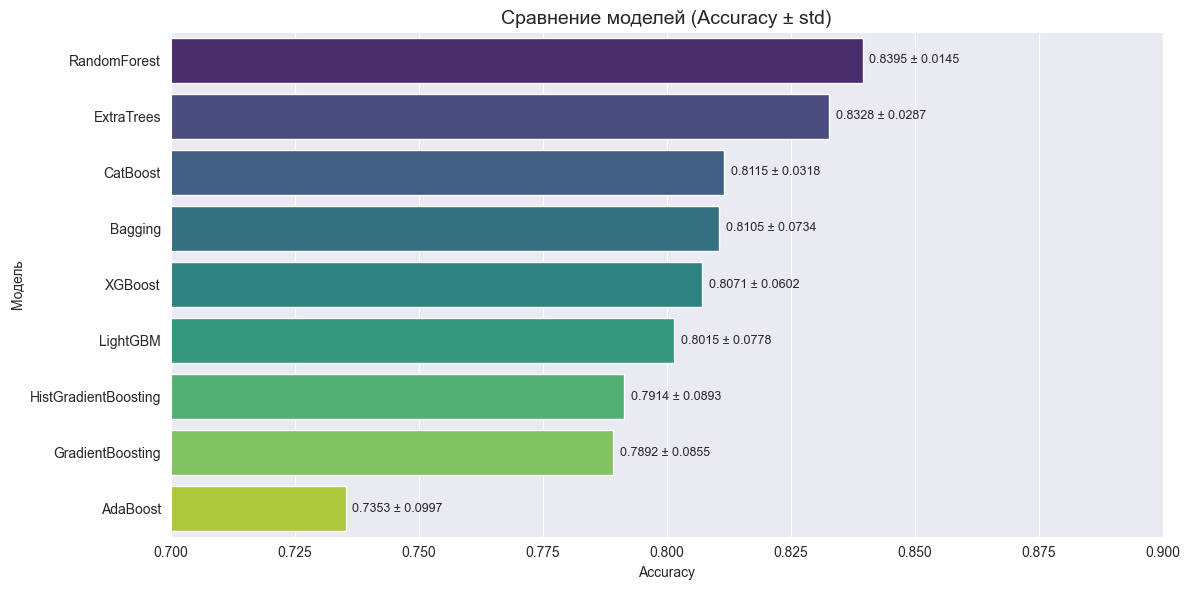

In [93]:
# Создаем DataFrame с результатами
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)

# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
# График для Accuracy
ax = sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')

# Добавляем аннотации с отклонениями
for i, p in enumerate(ax.patches):
    model_name = results_df.iloc[i]['Model']
    acc = results_df[results_df['Model'] == model_name]['Accuracy'].values[0]
    std = results_df[results_df['Model'] == model_name]['Accuracy_std'].values[0]
    ax.annotate(f"{acc:.4f} ± {std:.4f}", 
                (p.get_width(), p.get_y() + p.get_height()/2),
                ha='left', va='center', fontsize=9, xytext=(5, 0),
                textcoords='offset points')

plt.title('Сравнение моделей (Accuracy ± std)', fontsize=14)
plt.xlabel('Accuracy')
plt.ylabel('Модель')
plt.xlim(0.7, 0.9)  # Фиксируем диапазон для лучшего сравнения

plt.tight_layout()
plt.show()

In [94]:
# Вывод таблицы с результатами
print("\nПодробные результаты кросс-валидации:")
display(results_df[['Model', 'Accuracy', 'Accuracy_std', 'Time (s)']].style\
    .background_gradient(cmap='Blues', subset=['Accuracy'])\
    .format({
        'Accuracy': '{:.4f}',
        'Accuracy_std': '{:.4f}',
        'Time (s)': '{:.2f}'
    }))


Подробные результаты кросс-валидации:


,Model,Accuracy,Accuracy_std,Time (s)
0,RandomForest,0.8395,0.0145,1.19
2,ExtraTrees,0.8328,0.0287,0.68
8,CatBoost,0.8115,0.0318,0.63
4,Bagging,0.8105,0.0734,0.82
6,XGBoost,0.8071,0.0602,0.19
7,LightGBM,0.8015,0.0778,0.62
5,HistGradientBoosting,0.7914,0.0893,0.12
1,GradientBoosting,0.7892,0.0855,0.71
3,AdaBoost,0.7353,0.0997,0.68


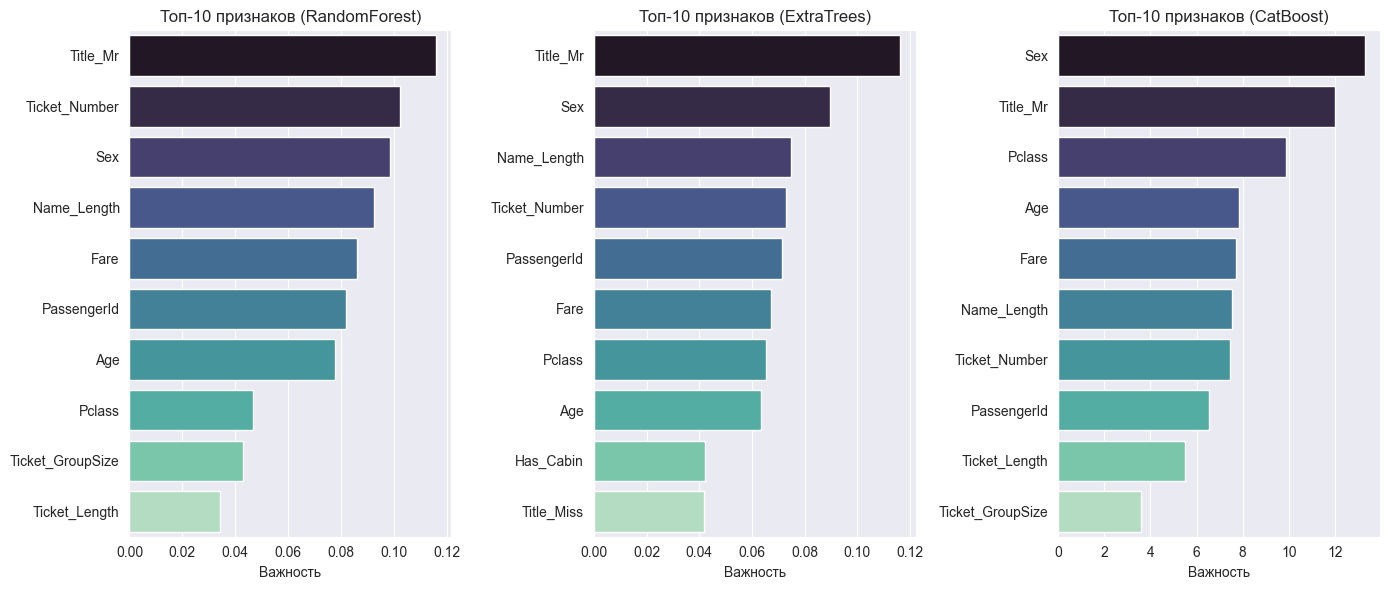

In [95]:
# Анализ важности признаков для топ-3 моделей
plt.figure(figsize=(14, 6))
top_models = results_df.head(3)['Model'].values

for i, model_name in enumerate(top_models, 1):
    plt.subplot(1, 3, i)
    
    # Создаем DataFrame с важностями
    importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances[model_name]
    }).sort_values('Importance', ascending=False).head(10)  # Топ-10 признаков
    
    # График
    sns.barplot(x='Importance', y='Feature', data=importances, palette='mako')
    plt.title(f'Топ-10 признаков ({model_name})', fontsize=12)
    plt.xlabel('Важность')
    plt.ylabel('')

plt.tight_layout()
plt.show()

<p style = "background-color : #0090ff; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Остался submission:</span>

<div style="text-align: center;">
    <img src="png//fin.png" alt="one" width="1000"/>
</div>

In [96]:
# Разделяем данные на обучающую и тестовую выборки
train_data = df_titan[df_titan['sample'] == 1]
test_data = df_titan[df_titan['sample'] == 0]

# Целевая переменная
y_train = train_data['Survived']

# Признаки (удаляем sample и Survived)
X_train = train_data.drop(['sample', 'Survived'], axis=1)
X_test = test_data.drop(['sample', 'Survived'], axis=1)

# Проверяем размерности
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Инициализируем RandomForestClassifier с оптимальными параметрами
rf_model = RandomForestClassifier(
    n_estimators=100,  
    random_state=42
)

    
# Обучаем модель
rf_model.fit(X_train, y_train)

# Делаем предсказания на тестовых данных
test_predictions = rf_model.predict(X_test)

# Подготовка submission файла
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],  # Убедитесь, что название столбца правильное
    'Survived': test_predictions
})

# # Сохраняем в CSV
submission.to_csv('submission.csv', index=False)

print("ExtraTrees submission file created successfully!")

Train shape: (891, 27), Test shape: (418, 27)
ExtraTrees submission file created successfully!


In [97]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
